In [ ]:
!pip install fastai==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 187 kB 5.4 MB/s 
     |████████████████████████████████| 831.4 MB 6.8 kB/s 
     |████████████████████████████████| 55 kB 5.1 MB/s 
     |████████████████████████████████| 19.1 MB 970 kB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     |████████████████████████████████| 23.3 MB 97.8 MB/s 
     |████████████████████████████████| 23.3 MB 1.4 MB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successful

In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [ ]:
path = coco_path

In [ ]:
import glob
import numpy as np
import os

In [ ]:
paths = glob.glob(path + "/*.jpg")
np.random.seed(123)
paths_subset = np.random.choice(paths, 10000, replace=False)
rand_idxs = np.random.permutation(10000)
train_idxs = rand_idxs[:8000]
val_idxs = rand_idxs[8000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

In [ ]:
len(train_paths)

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

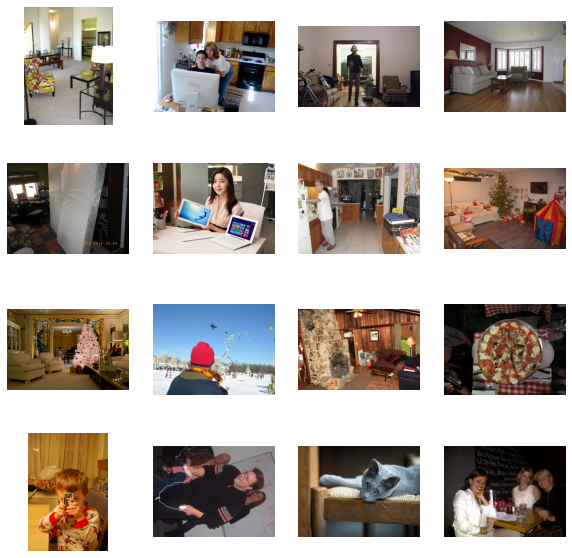

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

In [ ]:
SIZE = 256

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, split="train"):
        if split == "train":
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE), Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == "val":
            self.transforms = transforms.Resize((SIZE, SIZE), Image.BICUBIC)
        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1.
        ab = img_lab[[1, 2], ...] / 110.
        return {"L": L, "ab": ab}
    
    def __len__(self):
        return len(self.paths)

In [ ]:
def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split="train")
val_dl = make_dataloaders(paths=val_paths, split="val")

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_dl))

In [ ]:
print(len(train_dl), len(val_dl))

500 125


In [ ]:
print(data["L"].shape, data["ab"].shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])


In [ ]:
import torch
from torch import nn, optim

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        return torch.cat([x, self.model(x)], 1)
        

In [ ]:
class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=1, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s = 1 if i == (n_down - 1) else 2) for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s = 1, norm=False, act=False)]
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm:
            layers += [nn.BatchNorm2d(nf)]
        if act:
            layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256)
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode="vanilla", real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer("real_label", torch.tensor(real_label))
        self.register_buffer("fake_label", torch.tensor(fake_label))
        if gan_mode == "vanilla":
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == "lsgan":
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init="norm", gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, "weight") and "Conv" in classname:
            if init == "norm":
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == "xavier":
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == "kaiming":
                nn.init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
            if hasattr(m, "bias") and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif "BatchNorm2d" in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
    
    net.apply(init_func)
    print(f"Model initialized with {init} initialization")
    return net

In [ ]:
def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode="vanilla").to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
    
    def setup_input(self, data):
        self.L = data["L"].to(self.device)
        self.ab = data["ab"].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

In [ ]:
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    return {"loss_D_fake": loss_D_fake, "loss_D_real": loss_D_real, "loss_D": loss_D, "loss_G_GAN": loss_G_GAN, "loss_G_L1": loss_G_L1, "loss_G": loss_G}

In [ ]:
def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

In [ ]:
def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [ ]:
import time
from tqdm.notebook import tqdm

In [ ]:
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap="gray")
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

In [ ]:
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl))
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data["L"].size(0))
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e + 1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)
                visualize(model, data, save=False)

In [ ]:
model = MainModel()

Model initialized with norm initialization
Model initialized with norm initialization


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/5
Iteration 200/500
loss_D_fake: 0.47338
loss_D_real: 0.49302
loss_D: 0.48320
loss_G_GAN: 1.62439
loss_G_L1: 10.05018
loss_G: 11.67457


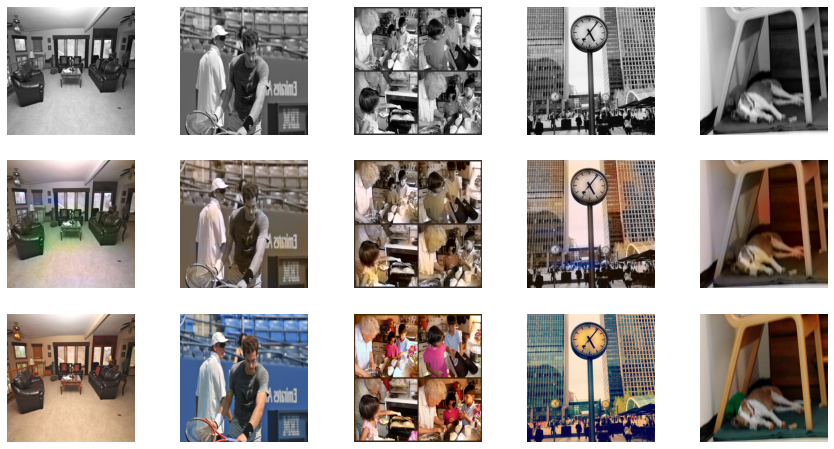


Epoch 1/5
Iteration 400/500
loss_D_fake: 0.47561
loss_D_real: 0.49395
loss_D: 0.48478
loss_G_GAN: 1.54629
loss_G_L1: 10.26346
loss_G: 11.80975


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


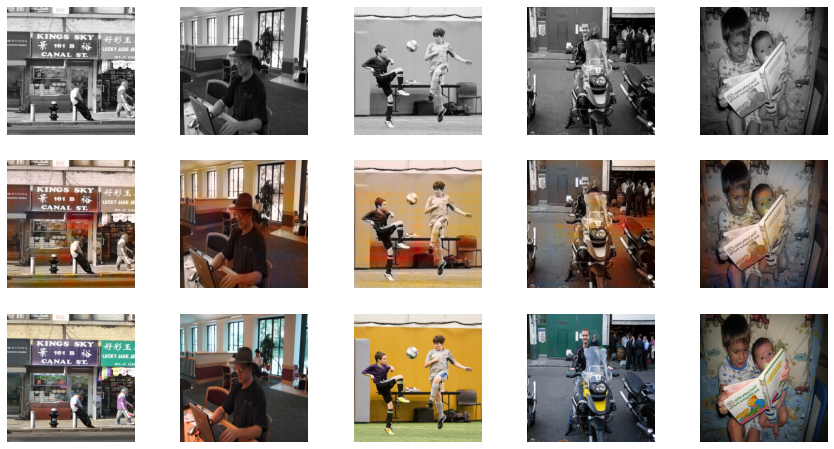

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/5
Iteration 200/500
loss_D_fake: 0.51448
loss_D_real: 0.55290
loss_D: 0.53369
loss_G_GAN: 1.36998
loss_G_L1: 10.83960
loss_G: 12.20958


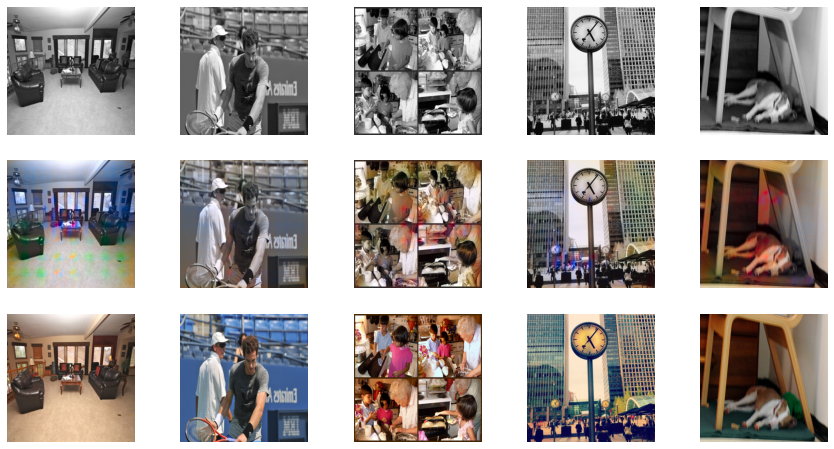


Epoch 2/5
Iteration 400/500
loss_D_fake: 0.51897
loss_D_real: 0.55793
loss_D: 0.53845
loss_G_GAN: 1.32776
loss_G_L1: 10.83767
loss_G: 12.16544


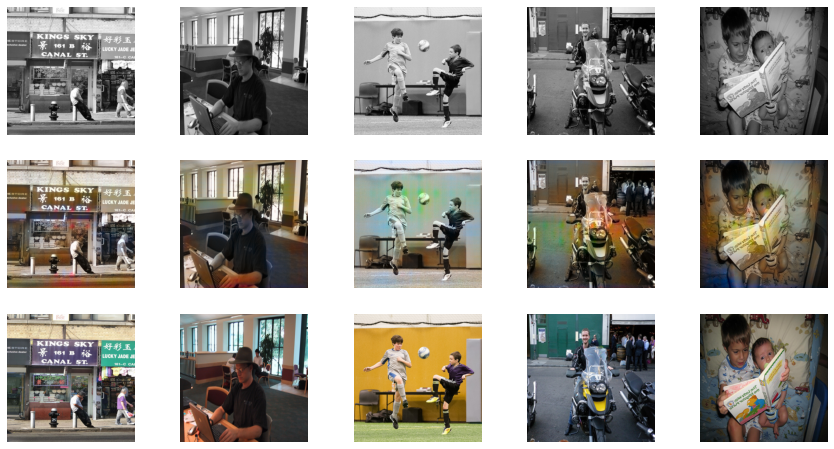

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3/5
Iteration 200/500
loss_D_fake: 0.51963
loss_D_real: 0.57166
loss_D: 0.54565
loss_G_GAN: 1.32493
loss_G_L1: 10.95944
loss_G: 12.28437


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 29 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


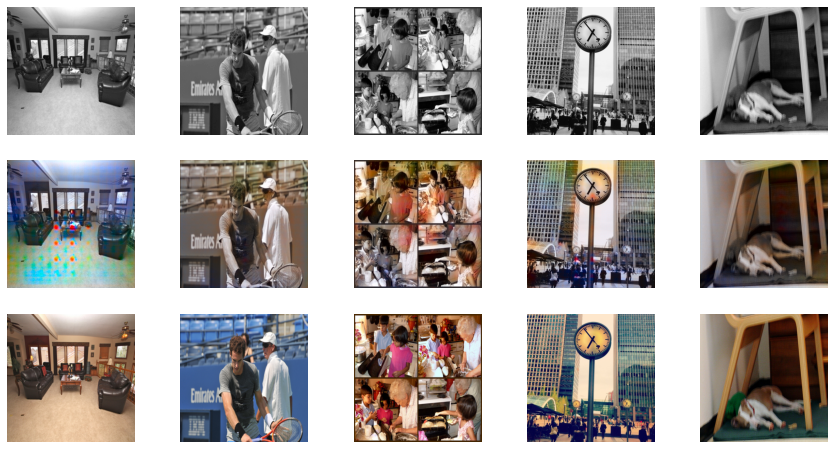


Epoch 3/5
Iteration 400/500
loss_D_fake: 0.52678
loss_D_real: 0.57282
loss_D: 0.54980
loss_G_GAN: 1.28253
loss_G_L1: 10.90604
loss_G: 12.18857


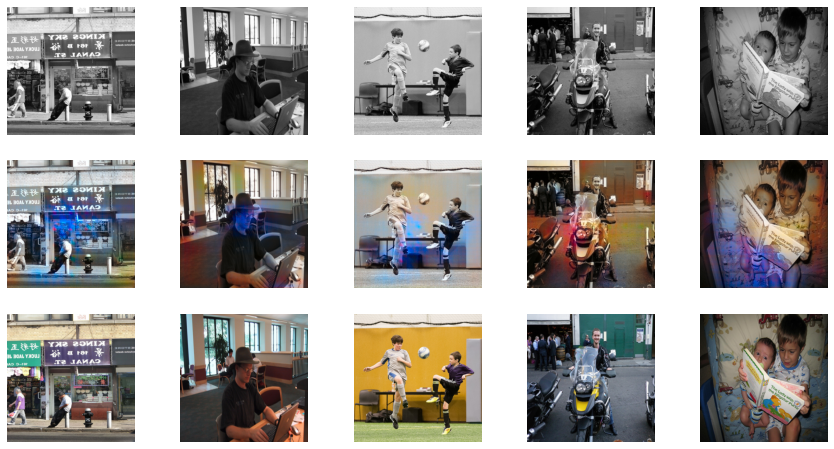

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4/5
Iteration 200/500
loss_D_fake: 0.51807
loss_D_real: 0.56978
loss_D: 0.54393
loss_G_GAN: 1.28800
loss_G_L1: 10.89483
loss_G: 12.18283


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


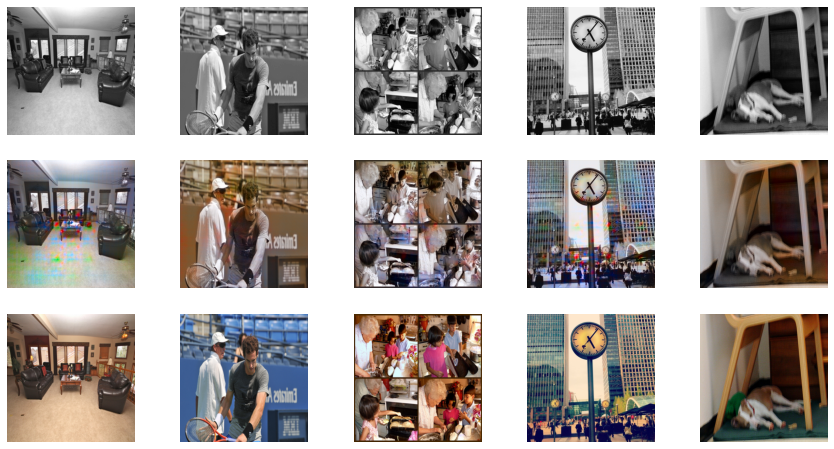


Epoch 4/5
Iteration 400/500
loss_D_fake: 0.52290
loss_D_real: 0.56989
loss_D: 0.54640
loss_G_GAN: 1.26007
loss_G_L1: 10.86880
loss_G: 12.12888


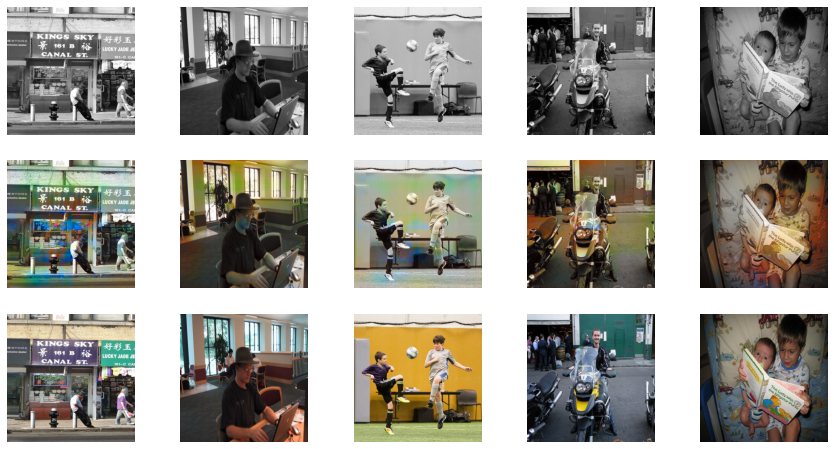

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5/5
Iteration 200/500
loss_D_fake: 0.53572
loss_D_real: 0.58050
loss_D: 0.55811
loss_G_GAN: 1.24990
loss_G_L1: 10.91634
loss_G: 12.16624


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 46 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 68 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 122 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


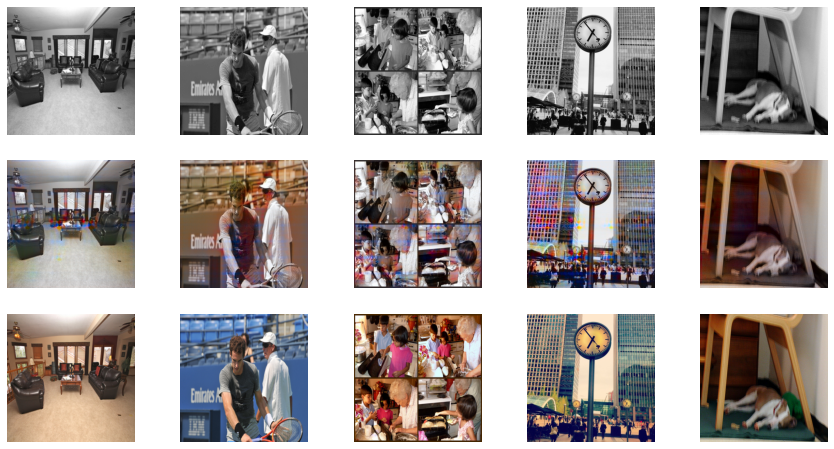


Epoch 5/5
Iteration 400/500
loss_D_fake: 0.53851
loss_D_real: 0.58292
loss_D: 0.56072
loss_G_GAN: 1.22401
loss_G_L1: 10.87783
loss_G: 12.10184


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 22 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 126 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


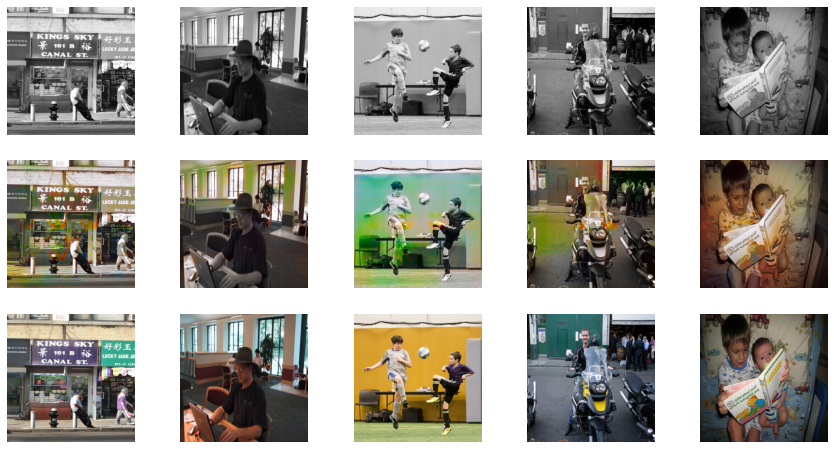

In [ ]:
train_model(model, train_dl, 5)

In [ ]:
torch.save(model, "./model-1.pth")

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 5)
torch.save(net_G.state_dict(), "res18-unet.pt")

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/5
L1 Loss: 0.08625


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/5
L1 Loss: 0.08270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/5
L1 Loss: 0.08213


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/5
L1 Loss: 0.08168


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/5
L1 Loss: 0.08129


In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("final_model_weights.pt", map_location=device))

Model initialized with norm initialization


<All keys matched successfully>